The objective of this project is to investigate betting inefficiencies in Premier League odds for the years 2005-2024.

In our analysis we explore 3 biases:
1. Home bias: Bettors overestimate the home advantage (betting on Home teams).
2. Favorite-Longshort Bias: Overvaluation of underdogs, undervaluation of favorites (betting on promoted teams).
3. Sentiment bias: Odds skew towards popular teams (betting on most popular team as quantified by attendance).

We have divided the code into several paragraphs with headings to make the code more readable. In our analysis, we:
1. Run a logistic regression on Home and Away wins.
2. Check for profitable strategies.
3. Run some Monte Carlo Simulations.

Note that the Monte Carlo Simulations may take very long to run. 

In the end, we provide a brief interpretation of the results obtained.

Importing necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
import datetime as dt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

##### Reading files and cleaning/filtering data

Read the necessary csv files in the data directory and make each a global variable.
(Must change directory!!!)

In [3]:
data_dir = "../data/Prem data" 

for file_name in sorted(os.listdir(data_dir)):
    if file_name.endswith(".csv") and file_name.startswith("Prem"):
        # Extract the file identifier (e.g. 0405, 2324, etc.)
        season = file_name.split(" ")[1].split(".")[0].replace("-", "")
        key = f"pl_{season}"  # Create the variable name in the correct format
        # Read the CSV file with a compatible encoding
        file_path = os.path.join(data_dir, file_name)
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='latin-1')

        # Assign the DataFrame to a dynamic variable using globals()
        globals()[key] = df
        print(f"Archive {file_name} uploaded as {key}")

# Verify that the variables have been created
created_vars = [var for var in globals() if var.startswith("pl_")]
print("Created variables:", created_vars)

Archive Prem 04-05.csv uploaded as pl_0405
Archive Prem 05-06.csv uploaded as pl_0506
Archive Prem 06-07.csv uploaded as pl_0607
Archive Prem 07-08.csv uploaded as pl_0708
Archive Prem 08-09.csv uploaded as pl_0809
Archive Prem 09-10.csv uploaded as pl_0910
Archive Prem 10-11.csv uploaded as pl_1011
Archive Prem 11-12.csv uploaded as pl_1112
Archive Prem 12-13.csv uploaded as pl_1213
Archive Prem 13-14.csv uploaded as pl_1314
Archive Prem 14-15.csv uploaded as pl_1415
Archive Prem 15-16.csv uploaded as pl_1516
Archive Prem 16-17.csv uploaded as pl_1617
Archive Prem 17-18.csv uploaded as pl_1718
Archive Prem 18-19.csv uploaded as pl_1819
Archive Prem 19-20.csv uploaded as pl_1920
Archive Prem 20-21.csv uploaded as pl_2021
Archive Prem 21-22.csv uploaded as pl_2122
Archive Prem 22-23.csv uploaded as pl_2223
Archive Prem 23-24.csv uploaded as pl_2324
Created variables: ['pl_0405', 'pl_0506', 'pl_0607', 'pl_0708', 'pl_0809', 'pl_0910', 'pl_1011', 'pl_1112', 'pl_1213', 'pl_1314', 'pl_1415',

In [4]:
common_cols = pl_0506.columns.intersection(pl_2021.columns)

Dynamically filters DataFrames for common columns of season 05-06 and 20-21. Then saves the filtered versions as new variables.

In [5]:
seasons = [
    "0506", "0607", "0708", "0809", "0910", "1011", "1112", "1213",
    "1314", "1415", "1516", "1617", "1718", "1819", "1920", "2021",
    "2122", "2223", "2324"
]

# Apply the common filter to all the variables
for season in seasons:
    original_var = f"pl_{season}"  # Name of the original variable
    filtered_var = f"pl_{season}_filtered"  # Name of the filtered variable
    if original_var in globals():
        df = globals()[original_var]
        # Verify which columns of common_cols are in the DataFrame
        valid_cols = [col for col in common_cols if col in df.columns]
        if valid_cols:
            globals()[filtered_var] = df[valid_cols]
            print(f"Variable {filtered_var} created with columns: {valid_cols}")
        else:
            print(f"Warning: None of the columns of common_cols is in {original_var}")

Variable pl_0506_filtered created with columns: ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']
Variable pl_0607_filtered created with columns: ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']
Variable pl_0708_filtered created with columns: ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']
Variable p

In [6]:
pl_2324_filtered.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BWA,IWH,IWD,IWA,WHH,WHD,WHA,VCH,VCD,VCA
0,E0,11/08/2023,Burnley,Man City,0,3,A,0,2,A,...,1.34,8.00,5.50,1.35,8.00,5.0,1.25,9.50,5.25,1.33
1,E0,12/08/2023,Arsenal,Nott'm Forest,2,1,H,2,0,H,...,15.50,1.20,7.25,14.00,1.12,6.5,12.00,1.14,7.50,17.00
2,E0,12/08/2023,Bournemouth,West Ham,1,1,D,0,0,D,...,2.55,2.70,3.45,2.60,2.62,3.2,2.30,2.63,3.30,2.63
3,E0,12/08/2023,Brighton,Luton,4,1,H,1,0,H,...,9.00,1.35,5.25,8.50,1.25,4.6,8.50,1.29,5.25,10.00
4,E0,12/08/2023,Everton,Fulham,0,1,A,0,0,D,...,3.25,2.25,3.40,3.25,2.10,3.2,3.00,2.20,3.30,3.25


Drop columns not necessary for our analysis, such as the division (Div), half-time home goals (HTHG), home shots (HS), home fouls (HF) etc.

In [7]:
columns =  ["Div","HTHG","HTAG","HTR","Referee","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
for season in seasons:
    original_var = f"pl_{season}_filtered"  # Name of the filtered variable
    filtered_var = f"pl_{season}_f"  # Name of the final variable
    if original_var in globals():
        df = globals()[original_var]
        globals()[filtered_var] = df.drop(columns=columns, errors='ignore')  # Remove columns and handle errors
        print(f"Variable {filtered_var} created")

Variable pl_0506_f created
Variable pl_0607_f created
Variable pl_0708_f created
Variable pl_0809_f created
Variable pl_0910_f created
Variable pl_1011_f created
Variable pl_1112_f created
Variable pl_1213_f created
Variable pl_1314_f created
Variable pl_1415_f created
Variable pl_1516_f created
Variable pl_1617_f created
Variable pl_1718_f created
Variable pl_1819_f created
Variable pl_1920_f created
Variable pl_2021_f created
Variable pl_2122_f created
Variable pl_2223_f created
Variable pl_2324_f created


Fill in missing odds data with data from the platform Bet365, since this betting platform has complete data.

In [8]:
pl_2324_f["IWH"] = pl_2324_f["IWH"].fillna(pl_2324_f["B365H"])
pl_2324_f["IWD"] = pl_2324_f["IWD"].fillna(pl_2324_f["B365D"])
pl_2324_f["IWA"] = pl_2324_f["IWA"].fillna(pl_2324_f["B365A"])
pl_2324_f["BWH"] = pl_2324_f["BWH"].fillna(pl_2324_f["B365H"])
pl_2324_f["BWD"] = pl_2324_f["BWD"].fillna(pl_2324_f["B365D"])
pl_2324_f["BWA"] = pl_2324_f["BWA"].fillna(pl_2324_f["B365A"])

pl_1516_f["BWH"] = pl_1516_f["BWH"].fillna(pl_1516_f["B365H"])
pl_1516_f["BWD"] = pl_1516_f["BWD"].fillna(pl_1516_f["B365D"])
pl_1516_f["BWA"] = pl_1516_f["BWA"].fillna(pl_1516_f["B365A"])

pl_1415_f["IWH"] = pl_1415_f["IWH"].fillna(pl_1415_f["B365H"])
pl_1415_f["IWD"] = pl_1415_f["IWD"].fillna(pl_1415_f["B365D"])
pl_1415_f["IWA"] = pl_1415_f["IWA"].fillna(pl_1415_f["B365A"])

pl_0809_f["IWH"] = pl_0809_f["IWH"].fillna(pl_0809_f["B365H"])
pl_0809_f["IWD"] = pl_0809_f["IWD"].fillna(pl_0809_f["B365D"])
pl_0809_f["IWA"] = pl_0809_f["IWA"].fillna(pl_0809_f["B365A"])

pl_0708_f["WHH"] = pl_0708_f["WHH"].fillna(pl_0708_f["B365H"])
pl_0708_f["WHD"] = pl_0708_f["WHD"].fillna(pl_0708_f["B365D"])
pl_0708_f["WHA"] = pl_0708_f["WHA"].fillna(pl_0708_f["B365A"])

In [9]:
pl_0506_f.isna().sum()

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
B365H       0
B365D       0
B365A       0
BWH         0
BWD         0
BWA         0
IWH         0
IWD         0
IWA         0
WHH         0
WHD         0
WHA         0
VCH         0
VCD         0
VCA         0
dtype: int64

In [10]:
pl_2324_f.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,BWH,...,BWA,IWH,IWD,IWA,WHH,WHD,WHA,VCH,VCD,VCA
375,19/05/2024,Crystal Palace,Aston Villa,5,0,H,1.85,4.33,3.60,1.88,...,3.50,1.85,4.33,3.60,1.85,4.2,3.5,1.80,4.00,3.7
376,19/05/2024,Liverpool,Wolves,2,0,H,1.17,8.00,15.00,1.17,...,14.00,1.17,8.00,15.00,1.14,8.5,15.0,1.13,8.00,15.0
377,19/05/2024,Luton,Fulham,2,4,A,2.90,3.90,2.20,2.87,...,2.20,2.90,3.90,2.20,2.80,4.0,2.2,2.88,3.75,2.2
378,19/05/2024,Man City,West Ham,3,1,H,1.08,12.00,21.00,1.11,...,19.50,1.08,12.00,21.00,1.07,12.0,21.0,1.07,10.50,22.0
379,19/05/2024,Sheffield United,Tottenham,0,3,A,7.00,6.00,1.33,7.25,...,1.33,7.00,6.00,1.33,7.50,6.0,1.3,7.50,5.75,1.3


##### Calculate Average and Implied Odds

Calculate the average Home Odds across sites for each season. 

In [11]:
columns_to_sum = ["B365H", "BWH", "IWH", "WHH", "VCH"]

# Function to calculate “Avg Home Odds” (average across sites)
def calculate_avg_home_odds(df, columns):
    return 0.2 * df[columns].sum(axis=1)

# Apply the calculation for each season
for season in seasons:
    filtered_var = f"pl_{season}_f"
    if filtered_var in globals():
        df = globals()[filtered_var]
        df["Avg Home Odds"] = calculate_avg_home_odds(df, columns_to_sum)
        print(f"Avg Home Odds calculated for {filtered_var}")

Avg Home Odds calculated for pl_0506_f
Avg Home Odds calculated for pl_0607_f
Avg Home Odds calculated for pl_0708_f
Avg Home Odds calculated for pl_0809_f
Avg Home Odds calculated for pl_0910_f
Avg Home Odds calculated for pl_1011_f
Avg Home Odds calculated for pl_1112_f
Avg Home Odds calculated for pl_1213_f
Avg Home Odds calculated for pl_1314_f
Avg Home Odds calculated for pl_1415_f
Avg Home Odds calculated for pl_1516_f
Avg Home Odds calculated for pl_1617_f
Avg Home Odds calculated for pl_1718_f
Avg Home Odds calculated for pl_1819_f
Avg Home Odds calculated for pl_1920_f
Avg Home Odds calculated for pl_2021_f
Avg Home Odds calculated for pl_2122_f
Avg Home Odds calculated for pl_2223_f
Avg Home Odds calculated for pl_2324_f


Calculate the average odds and the implied probabilities for a home win, draw and away win in each season, adding the results as a new column in the dataframe for each season.

In [12]:
# List of DataFrames per year
data_frames = [
    pl_2324_f, pl_2223_f, pl_2122_f, pl_2021_f, pl_1920_f, pl_1819_f,
    pl_1718_f, pl_1617_f, pl_1516_f, pl_1415_f, pl_1314_f, pl_1213_f,
    pl_1112_f, pl_1011_f, pl_0910_f, pl_0809_f, pl_0708_f, pl_0607_f, pl_0506_f
]

# Function for calculating the averages of the probabilities
def calculate_avg_odds(df, odds_columns, avg_column_name):
    df[avg_column_name] = 0.2 * df[odds_columns].sum(axis=1)

# Function for calculating implied probabilities: probability of home win over sum of the probabilities of home,draw,away
def calculate_implied_prob(df, avg_home_odds, avg_draw_odds, avg_away_odds, home_prob_col, draw_prob_col, away_prob_col):
    df[home_prob_col] = (1 / df[avg_home_odds]) / (
        (1 / df[avg_home_odds]) + (1 / df[avg_draw_odds]) + (1 / df[avg_away_odds])
    )
    df[away_prob_col] = (1 / df[avg_away_odds]) / (
        (1 / df[avg_home_odds]) + (1 / df[avg_draw_odds]) + (1 / df[avg_away_odds])
    )
    df[draw_prob_col] = (1 / df[avg_draw_odds]) / (
        (1 / df[avg_home_odds]) + (1 / df[avg_draw_odds]) + (1 / df[avg_away_odds])
    )

# Define the columns of probabilities
home_odds_columns = ["B365H", "BWH", "IWH", "WHH", "VCH"]
draw_odds_columns = ["B365D", "BWD", "IWD", "WHD", "VCD"]
away_odds_columns = ["B365A", "BWA", "IWA", "WHA", "VCA"]

# Iterate on each DataFrame
for df in data_frames:
    # Calculate the averages of the probabilities
    calculate_avg_odds(df, home_odds_columns, "Avg Home Odds")
    calculate_avg_odds(df, draw_odds_columns, "Avg Draw Odds")
    calculate_avg_odds(df, away_odds_columns, "Avg Away Odds")

    # Calculate the implied probabilities for “Home”, “Draw” and “Away”
    calculate_implied_prob(df, "Avg Home Odds", "Avg Draw Odds", "Avg Away Odds",
                           "Implied Home Prob", "Implied Draw Prob", "Implied Away Prob")


In [13]:
pl_2324_f["Implied Home Prob"]

0      0.111162
1      0.805435
2      0.351237
3      0.716380
4      0.427729
         ...   
375    0.511246
376    0.819707
377    0.328695
378    0.873327
379    0.129546
Name: Implied Home Prob, Length: 380, dtype: float64

In [14]:
pl_2324_f["Implied Away Prob"]

0      0.711607
1      0.063668
2      0.369870
3      0.104114
4      0.291815
         ...   
375    0.263620
376    0.064026
377    0.428797
378    0.045212
379    0.712603
Name: Implied Away Prob, Length: 380, dtype: float64

In [15]:
pl_2324_f["Implied Draw Prob"]

0      0.177230
1      0.130897
2      0.278893
3      0.179507
4      0.280457
         ...   
375    0.225134
376    0.116268
377    0.242508
378    0.081460
379    0.157851
Name: Implied Draw Prob, Length: 380, dtype: float64

Create two new columns: The column BetH_Home is always 1 (a win), the column BetA_Home is always 0 (a loss).

In [16]:
# List of DataFrames per year
data_frames = [
    pl_2324_f, pl_2223_f, pl_2122_f, pl_2021_f, pl_1920_f, pl_1819_f,
    pl_1718_f, pl_1617_f, pl_1516_f, pl_1415_f, pl_1314_f, pl_1213_f,
    pl_1112_f, pl_1011_f, pl_0910_f, pl_0809_f, pl_0708_f, pl_0607_f, pl_0506_f
]

# Iterate over each DataFrame to assign the BetH_Home and BetA_Home columns
for df in data_frames:
    df["BetH_Home"] = 1  # Assign 1 to column BetH_Home
    df["BetA_Home"] = 0  # Assign 0 to column BetA_Home


##### Add data on Promoted Teams and Attendance to the dataset

Define the promoted teams for each season. Create columns that indicate bets involving promoted teams (betting on or against promoted teams), depending on whether the Home and the Away team is promoted, for each season.

In [17]:
teams_by_season = {
    "2324": ["Burnley", "Sheffield United", "Luton"],
    "2223": ["Fulham", "Bournemouth", "Nott'm Forest"],
    "2122": ["Norwich", "Watford", "Brentford"],
    "2021": ["Leeds", "West Brom", "Fulham"],
    "1920": ["Norwich", "Sheffield United", "Aston Villa"],
    "1819": ["Wolves", "Cardiff", "Fulham"],
    "1718": ["Newcastle", "Brighton", "Huddersfield"],
    "1617": ["Burnley", "Middlesbrough", "Hull"],
    "1516": ["Bournemouth", "Watford", "Norwich"],
    "1415": ["Leicester", "Burnley", "QPR"],
    "1314": ["Cardiff", "Hull", "Crystal Palace"],
    "1213": ["Reading", "Southampton", "West Ham"],
    "1112": ["QPR", "Norwich", "Swansea"],
    "1011": ["Newcastle", "West Brom", "Blackpool"],
    "0910": ["Wolves", "Birmingham", "Burnley"],
    "0809": ["West Brom", "Stoke", "Hull"],
    "0708": ["Sunderland", "Birmingham", "Derby"],
    "0607": ["Reading", "Sheffield United", "Watford"],
    "0506": ["Sunderland", "Wigan", "West Ham"]
}

# List of dataframes
dataframes = [pl_2324_f, pl_2223_f, pl_2122_f, pl_2021_f, pl_1920_f, pl_1819_f,
              pl_1718_f, pl_1617_f, pl_1516_f, pl_1415_f, pl_1314_f, pl_1213_f,
              pl_1112_f, pl_1011_f, pl_0910_f, pl_0809_f, pl_0708_f, pl_0607_f,
              pl_0506_f]

# Function to assign the 'Bet' columns based on the season and teams
def assign_bets(df, teams):
    df["BetH_OnPromH"] = 0
    df["BetH_OnPromA"] = 0
    df["BetH_VsPromH"] = 0
    df["BetH_VsPromA"] = 0
    df["BetA_Home"] = 0
    df["BetA_OnPromH"] = 0
    df["BetA_OnPromA"] = 0
    df["BetA_VsPromH"] = 0
    df["BetA_VsPromA"] = 0

    # Identify matches where the home team is the promoted team and the away team is not the promoted team.
    condition_home = df["HomeTeam"].isin(teams) & ~df["AwayTeam"].isin(teams)
    # Identify matches where the away team is the promoted team and the home team is not the promoted team.
    condition_away = ~df["HomeTeam"].isin(teams) & df["AwayTeam"].isin(teams)

    # Assign values directly using conditions
    df.loc[condition_home, "BetH_OnPromH"] = 1
    df.loc[condition_home, "BetA_VsPromH"] = 1
    df.loc[condition_away, "BetH_VsPromA"] = 1
    df.loc[condition_away, "BetA_OnPromA"] = 1

# Apply the function to all dataframes
for year, teams in teams_by_season.items():
    df = globals()[f"pl_{year}_f"]
    assign_bets(df, teams)

In [18]:
pl_2223_f.head(20)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,BWH,...,BetH_Home,BetA_Home,BetH_OnPromH,BetH_OnPromA,BetH_VsPromH,BetH_VsPromA,BetA_OnPromH,BetA_OnPromA,BetA_VsPromH,BetA_VsPromA
0,05/08/2022,Crystal Palace,Arsenal,0,2,A,4.20,3.60,1.85,4.33,...,1,0,0,0,0,0,0,0,0,0
1,06/08/2022,Fulham,Liverpool,2,2,D,11.00,6.00,1.25,10.00,...,1,0,1,0,0,0,0,0,1,0
2,06/08/2022,Bournemouth,Aston Villa,2,0,H,3.75,3.50,2.00,3.75,...,1,0,1,0,0,0,0,0,1,0
3,06/08/2022,Leeds,Wolves,2,1,H,2.25,3.40,3.20,2.30,...,1,0,0,0,0,0,0,0,0,0
4,06/08/2022,Newcastle,Nott'm Forest,2,0,H,1.66,3.80,5.25,1.65,...,1,0,0,0,0,1,0,1,0,0
5,06/08/2022,Tottenham,Southampton,4,1,H,1.33,5.50,8.50,1.35,...,1,0,0,0,0,0,0,0,0,0
6,06/08/2022,Everton,Chelsea,0,1,A,5.50,4.00,1.61,5.50,...,1,0,0,0,0,0,0,0,0,0
7,07/08/2022,Leicester,Brentford,2,2,D,2.00,3.75,3.50,2.00,...,1,0,0,0,0,0,0,0,0,0
8,07/08/2022,Man United,Brighton,1,2,A,1.60,4.20,5.25,1.62,...,1,0,0,0,0,0,0,0,0,0
9,07/08/2022,West Ham,Man City,0,2,A,8.00,5.00,1.36,7.75,...,1,0,0,0,0,0,0,0,0,0


Add data on attendance to our dataframe. (Must change directory!!!)

In [19]:
seasons = [
    "2324", "2223", "2122", "1819", "1718", "1617",
    "1516", "1415", "1314", "1213", "1112", "1011",
    "0910", "0809", "0708", "0607", "0506"
]

base_path = "../data/Premier AttDiff/"

# Go through each season and perform the merge
for season in seasons:
    # Attendance file path for each season
    path = f"{base_path}{season}_PL.xlsx"

    # Read the corresponding attendance file
    at_season = pd.read_excel(path)

    # Get the DataFrame of the season (e.g., pl_2324_f)
    df_name = f"pl_{season}_f"
    df_season = globals()[df_name]

    # Perform the merge
    pl_season = pd.merge(df_season, at_season, on=['HomeTeam', 'AwayTeam'], how='left')

    # Rename column 'SpectatorDifference' to 'DiffAttend' if it exists
    if 'SpectatorDifference' in pl_season.columns:
        pl_season.rename(columns={'SpectatorDifference': 'DiffAttend'}, inplace=True)

    # Save the result in the corresponding global variable
    globals()[f"pl_{season}"] = pl_season

##### Logistic Regression on Home and Away wins

Define a function to determine whether a bet is won

In [20]:
def calculate_won(row):
    if (row['BetH_Home'] == 1 and row['FTR'] == "H") or (row['BetH_Home'] == 0 and row['FTR'] == "A"):
        return 1
    return 0

# List of DataFrames
pl_list = [pl_2324, pl_2223, pl_2122, pl_2021_f, pl_1920_f, pl_1819, pl_1718, pl_1617,
           pl_1516, pl_1415, pl_1314, pl_1213, pl_1112, pl_1011, pl_0910, pl_0809,
           pl_0708, pl_0607, pl_0506]

# Apply the function to each DataFrame
for pl in pl_list:
    pl["Won"] = pl.apply(calculate_won, axis=1)

We run a logistic regression to predict whether the Home win in each season, based on 
1. Implied Home Probability, 
2. Whether a bet was placed on the home team, and
3. Attendance differences (home advantage).

We want to find out which factors are most important for predicting home wins and how these factors change across seasons.

In [21]:
# Logistic Regression Home Bets Model 1

seasons = [
    "2324", "2223", "2122", "1819", "1718", "1617",
    "1516", "1415", "1314", "1213", "1112", "1011",
    "0910", "0809", "0708", "0607", "0506"
]

# Dictionary for storing results of each season
results = {}

# Iterate over each season to perform logistic regression
for season in seasons:
    # Get the corresponding DataFrame
    pl_season = globals()[f"pl_{season}"]

    # Define independent and dependent variables
    X = pl_season[['Implied Home Prob', 'BetH_Home', 'DiffAttend']]
    y = pl_season['Won']

    # Add constant to the model
    X = sm.add_constant(X)

    # Create and adjust the model
    model = sm.Logit(y, X)
    result = model.fit()

    # Save the result in the dictionary
    results[season] = result

# Print summaries of all seasons
for season, result in results.items():
    print(f"Summary for Season {season}:\n")
    print(result.summary())

Optimization terminated successfully.
         Current function value: 0.577584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577284
  

In [22]:
X_2324 = pl_2324[['Implied Home Prob','BetH_Home','DiffAttend','BetH_OnPromH','BetH_VsPromH']]
corr = X_2324.corr()
corr

,Implied Home Prob,BetH_Home,DiffAttend,BetH_OnPromH,BetH_VsPromH
Implied Home Prob,1.000000,NaN,0.645596,-0.436369,NaN
BetH_Home,NaN,NaN,NaN,NaN,NaN
DiffAttend,0.645596,NaN,1.000000,-0.316207,NaN
BetH_OnPromH,-0.436369,NaN,-0.316207,1.000000,NaN
BetH_VsPromH,NaN,NaN,NaN,NaN,NaN


Fit the logistic regression for both Home and Away wins.

We exclude the seasons affected by the Covid pandemic, where in-person attendance was restricted.

Optimization terminated successfully.
         Current function value: 0.521627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605869
         Iterations 5


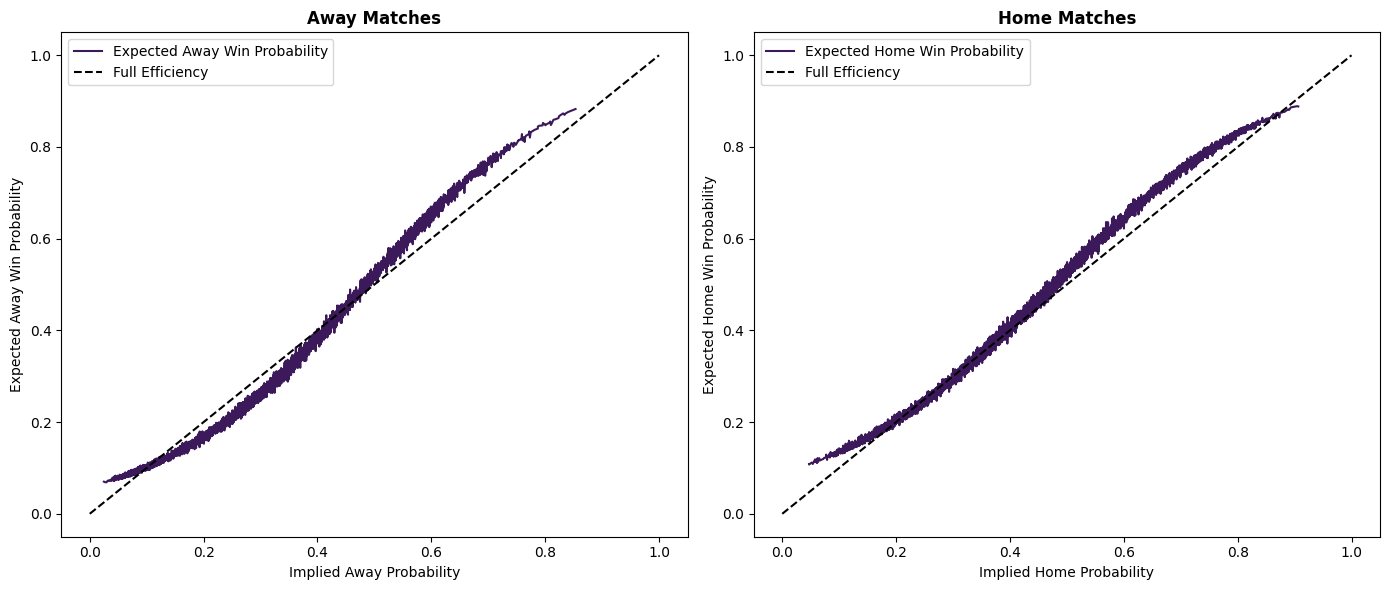

In [23]:
# List of seasons to analyze, excluding 2019/20 and 2020/21
seasons = ['2324', '2223', '2122', '2021', '1819', '1718', '1617',
           '1516', '1415', '1314', '1213', '1112', '1011', '0910',
           '0809', '0708', '0607', '0506']

# Initialize empty DataFrames for away and home matches
all_away_data = []
all_home_data = []

for season in seasons:
    pl = globals()[f'pl_{season}']

    # Ensure required columns are present
    if 'BetA_Home' in pl.columns:
        # Filter for away matches and add to the list
        pl_away_only = pl[pl['BetA_Home'] == 0]
        all_away_data.append(pl_away_only)

    # Ensure required columns are present for home matches
    if 'Implied Home Prob' in pl.columns and 'Won' in pl.columns:
        all_home_data.append(pl)

# Concatenate all the DataFrames for away and home matches
if all_away_data:
    away_matches_combined = pd.concat(all_away_data, ignore_index=True)
else:
    raise ValueError("No away matches data available.")

if all_home_data:
    home_matches_combined = pd.concat(all_home_data, ignore_index=True)
else:
    raise ValueError("No home matches data available.")

# Define predictors and target for away matches
X_away = away_matches_combined[['Implied Away Prob', 'DiffAttend']]
y_away = (away_matches_combined['FTR'] == 'A').astype(int)
X_away = sm.add_constant(X_away)

# Fit the logistic regression model for away matches
model_away = sm.Logit(y_away, X_away)
result_away = model_away.fit()

# Predict probabilities for away wins
away_matches_combined['Expected Away Win Prob'] = result_away.predict(X_away)
away_matches_combined = away_matches_combined.sort_values(by='Implied Away Prob')

# Define predictors and target for home matches
X_home = home_matches_combined[['Implied Home Prob', 'BetH_Home', 'DiffAttend']]
y_home = home_matches_combined['Won']
X_home = sm.add_constant(X_home)

# Fit the logistic regression model for home matches
model_home = sm.Logit(y_home, X_home)
result_home = model_home.fit()

# Predict probabilities for home wins
home_matches_combined['Expected Home Prob'] = result_home.predict(X_home)
home_matches_combined = home_matches_combined.sort_values(by='Implied Home Prob')

# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for away matches
sns.lineplot(ax=ax[0], x=away_matches_combined['Implied Away Prob'],
             y=away_matches_combined['Expected Away Win Prob'],
             label="Expected Away Win Probability", color="#3c195b")
ax[0].plot([0, 1], [0, 1], linestyle='--', color='black', label="Full Efficiency")
ax[0].set_title("Away Matches", fontweight='bold')
ax[0].set_xlabel("Implied Away Probability")
ax[0].set_ylabel("Expected Away Win Probability")
ax[0].legend()

# Plot for home matches
sns.lineplot(ax=ax[1], x=home_matches_combined['Implied Home Prob'],
             y=home_matches_combined['Expected Home Prob'],
             label="Expected Home Win Probability", color="#3c195b")
ax[1].plot([0, 1], [0, 1], linestyle='--', color='black', label="Full Efficiency")
ax[1].set_title("Home Matches", fontweight='bold')
ax[1].set_xlabel("Implied Home Probability")
ax[1].set_ylabel("Expected Home Win Probability")
ax[1].legend()

plt.tight_layout()
plt.show()

##### Calculate the cumulative and average return of betting on Home Teams

In [24]:
# List of DataFrames
dataframes = [
    pl_0506, pl_0607, pl_0708, pl_0809, pl_0910,
    pl_1011, pl_1112, pl_1213, pl_1314, pl_1415,
    pl_1516, pl_1617, pl_1718, pl_1819, pl_1920_f,
    pl_2021_f, pl_2122, pl_2223, pl_2324
]

# List of corresponding names
names = [
    "2005-06", "2006-07", "2007-08", "2008-09", "2009-10",
    "2010-11", "2011-12", "2012-13", "2013-14", "2014-15",
    "2015-16", "2016-17", "2017-18", "2018-19", "2019-20",
    "2020-21", "2021-22", "2022-23", "2023-24"
]

# Assign names using a loop
for df, name in zip(dataframes, names):
    df.name = name

Define a function to generate styled tables.

In [25]:
def create_styled_table(dataframe):
    # Configure the chart
    fig, ax = plt.subplots(figsize=(3.5, 6))
    ax.axis('off')

    # Create the table (without row labels)
    table = ax.table(cellText=dataframe.values,
                     colLabels=dataframe.columns,
                     cellLoc='center',
                     rowLoc='center',
                     loc='center')

    # Adjust size and general style
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Cell style
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(color='white', fontweight='bold')
            cell.set_facecolor('#3c195b')
        elif row == len(dataframe):
            cell.set_text_props(fontweight='bold')

    plt.show()

Calculate the cumulative and average return of the Home Bias trading strategy (betting only on home teams).

Then generate the styled table for the average season returns in percentages.

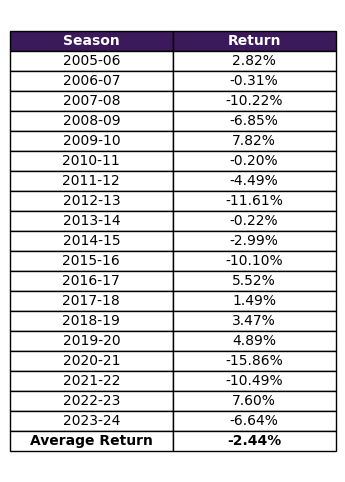

In [26]:
# Home Bias Trading function with PnL
def trading_home_with_pnl_returns(list_of_seasons, initial_bank, bet):
    cumulative_return = 0
    initial = initial_bank

    # Prepare to collect cumulative return data for each season
    all_season_returns_formatted = {}
    all_season_returns = {}

    for season_data in list_of_seasons:
        bank = initial

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["FTR"].iloc[i] == "H":  # If home team wins
                bank += bet * (season_data["Avg Home Odds"].iloc[i] - 1)
            else:  # If home team loses
                bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]

    return return_df

# Run the enhanced function with performance in return terms and return a DataFrame
returns_df = trading_home_with_pnl_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_1920_f, pl_2021_f, pl_2122, pl_2223, pl_2324],
    380,
    1
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Calculate the cumulative and average return of betting **ON** Promoted Teams at **Home** games.

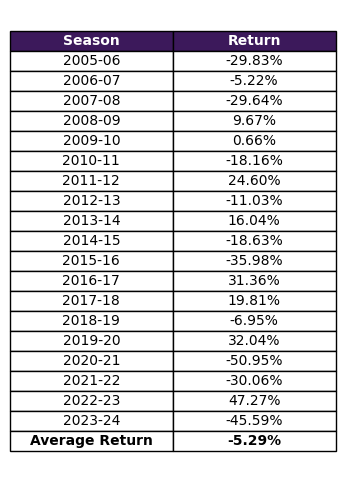

In [27]:
def trading_home_prom_with_pnl_returns(list_of_seasons, initial_bank, bet):
    initial = initial_bank
    cumulative_return = 0
    avg_return = 0

    # Prepare to collect cumulative return data for each season
    all_season_returns_formatted = {}
    all_season_returns = {}

    for season_data in list_of_seasons:
        bank = initial

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["BetH_OnPromH"].iloc[i] == 1:  # Bet on promoted team at home
                if season_data["FTR"].iloc[i] == "H":  # If home team wins
                    bank += bet * (season_data["Avg Home Odds"].iloc[i] - 1)
                else:  # If home team loses
                    bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]

    return return_df

# Run the enhanced function with performance in return terms and return a DataFrame
returns_df = trading_home_prom_with_pnl_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_1920_f, pl_2021_f, pl_2122, pl_2223, pl_2324],
    51,
    1
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Calculate the cumulative and average return of betting **ON** Promoted Teams at **Away** games.

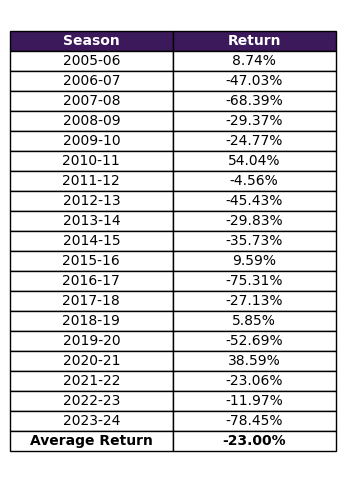

In [28]:
def trading_away_prom_with_returns(list_of_seasons, initial_bank, bet):
    initial = initial_bank  # Initial bank to calculate returns
    cumulative_return = 0  # Cumulative return tracker
    all_season_returns = {}  # Prepare to collect return data for each season
    all_season_returns_formatted = {} # Prepare to collect return data for each season

    for season_data in list_of_seasons:
        bank = initial

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["BetA_OnPromA"].iloc[i] == 1:  # Bet on promoted team away
                if season_data["FTR"].iloc[i] == "A":  # If away team wins
                    bank += bet * (season_data["Avg Away Odds"].iloc[i] - 1)
                else:  # If away team loses
                    bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]

    return return_df

# Run the enhanced function and get the DataFrame
returns_df = trading_away_prom_with_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_1920_f, pl_2021_f, pl_2122, pl_2223, pl_2324],
    51,
    1
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Calculate the cumulative and average return of betting **AGAINST** Promoted Teams at **Home** games.

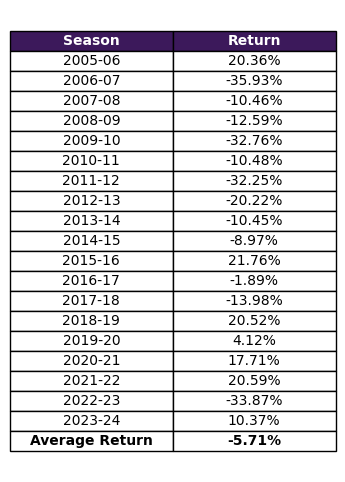

In [29]:
def trading_home_vs_prom_with_pnl_returns(list_of_seasons, initial_bank, bet):
    cumulative_return = 0
    initial = initial_bank
    all_season_returns = {}  # Prepare to collect return data for each season
    all_season_returns_formatted = {} # Prepare to collect return data for each season

    for season_data in list_of_seasons:
        bank = initial

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["BetA_VsPromH"].iloc[i] == 1:  # Bet against promoted team at home
                if season_data["FTR"].iloc[i] == "A":  # If away team wins
                    bank += bet * (season_data["Avg Away Odds"].iloc[i] - 1)
                else:  # If away team loses
                    bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]

    return return_df

# Run the enhanced function with performance in return terms and return a DataFrame
returns_df = trading_home_vs_prom_with_pnl_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_1920_f, pl_2021_f, pl_2122, pl_2223, pl_2324],
    51,
    1
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Calculate the cumulative and average return of betting **AGAINST** Promoted Teams at **Away** games.

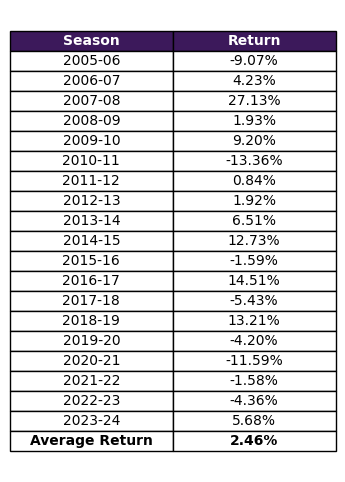

In [30]:
def trading_away_vs_prom_with_pnl_returns(list_of_seasons, initial_bank, bet):
    cumulative_return = 0
    initial = initial_bank
    all_season_returns = {}  # Prepare to collect return data for each season
    all_season_returns_formatted = {} # Prepare to collect return data for each season

    for season_data in list_of_seasons:
        bank = initial

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["BetH_VsPromA"].iloc[i] == 1:  # Bet against promoted team away
                if season_data["FTR"].iloc[i] == "H":  # If home team wins
                    bank += bet * (season_data["Avg Home Odds"].iloc[i] - 1)
                else:  # If away team loses
                    bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]

    return return_df

# Run the enhanced function with performance in return terms and return a DataFrame
returns_df = trading_away_vs_prom_with_pnl_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_1920_f, pl_2021_f, pl_2122, pl_2223, pl_2324],
    51,
    1
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Calculate the cumulative and average return of all home teams with DiffAttend exceeding 30,000.

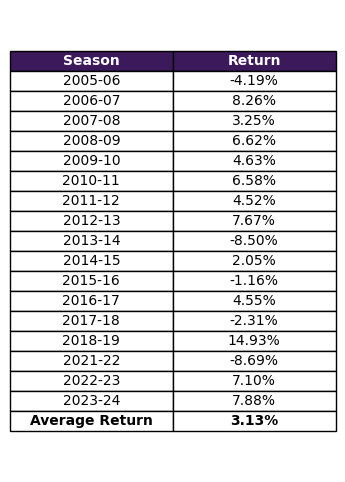

In [31]:
def trading_home_with_pnl_returns(list_of_seasons, initial_bank, bet, threshold):
    initial = initial_bank
    all_season_returns = {}  # Prepare to collect return data for each season
    all_season_returns_formatted = {} # Prepare to collect return data for each season
    cumulative_return = 0

    for season_data in list_of_seasons:
        bank = initial
        num_bets = 0

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["BetH_Home"].iloc[i] == 1 and season_data["DiffAttend"].iloc[i] > threshold:  # Bet on home team with DiffAttend > threshold
                num_bets += 1
                if season_data["FTR"].iloc[i] == "H":  # If home team wins
                    bank += bet * (season_data["Avg Home Odds"].iloc[i] - 1)
                else:  # If home team loses
                    bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]

    # View the DataFrame with the final returns and number of bets for each season
    return return_df

    # Run the function with performance in return terms and return a DataFrame
returns_df = trading_home_with_pnl_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_2122, pl_2223, pl_2324],
    51,
    1,
    30000
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Calculate the cumulative and average return of betting on the most popular teams.

We define "most popular" teams as the home matches with attendance differences in the top 5% (q95) for the season, indicating the highest fan turnout compared to the away team.

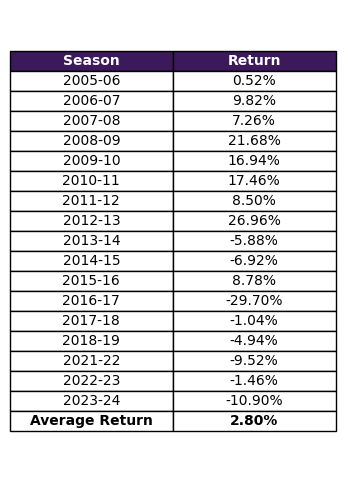

In [32]:
def trading_popular_with_pnl_returns(list_of_seasons, initial_bank, bet):
    cumulative_return = 0
    initial = initial_bank
    all_season_returns = {}  # Prepare to collect return data for each season
    all_season_returns_formatted = {} # Prepare to collect return data for each season

    for season_data in list_of_seasons:
        bank = initial
        q95 = season_data[season_data["DiffAttend"] > 0]["DiffAttend"].quantile(0.95)

        # Loop through matches and apply the betting strategy
        for i in range(len(season_data)):
            if season_data["DiffAttend"].iloc[i] >= q95:
                if season_data["FTR"].iloc[i] == "H":  # If home team wins
                    bank += bet * (season_data["Avg Home Odds"].iloc[i] - 1)
                else:  # If home team loses
                    bank -= bet

        # Calculate season return in percentage terms
        season_return = ((bank / initial) - 1) * 100
        cumulative_return += season_return
        season_return_formatted = f"{season_return:.2f}%"

        # Store final return for the season in percentage terms
        all_season_returns[season_data.name] = season_return
        all_season_returns_formatted[season_data.name] = season_return_formatted

    # Convert the dictionary to a DataFrame
    return_df = pd.DataFrame(list(all_season_returns_formatted.items()), columns=['Season', 'Return'])

    # Calculate cumulative return and add it to the DataFrame
    cumulative_return_value = f"{(cumulative_return / len(list_of_seasons)):.2f}%"
    average_return_value = f"{(sum(all_season_returns.values()) / len(list_of_seasons)):.2f}%"
    return_df.loc[len(return_df)] = ['Average Return', average_return_value]
    return return_df

# Run the enhanced function with performance in return terms and return a DataFrame
returns_df = trading_popular_with_pnl_returns(
    [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213, pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_2122, pl_2223, pl_2324],
    10,
    1
)

returns_df.reset_index(drop=True, inplace=True)

# Call the function
create_styled_table(returns_df)

##### Monte Carlo Simulations

We run 10,000 simulations to test if home teams consistently win more than expected using implied probabilities. We perform t-tests and check statistical significance of this home win bias for each season and calculate how often multiple seasons show a bias. 

We summarize the results in a table, with columns for each significance level (p=0.1, p=0.05, p=0.01). The rows show the number of seasons (out of 17) where home win bias was statistically significant in the simulations and the cells indicate the percentage of simulations where the number of significant seasons was larger or equal to the number of seasons in the corresponding row.

In [ ]:
# Parameters
num_simulations = 10000    # Number of Monte Carlo simulation runs
num_seasons = 17          # Number of seasons to simulate
alpha_levels = [0.1, 0.05, 0.01]  # Significance levels

# List of DataFrames for each season from pl_0506 to pl_2324 (already loaded into memory)
dataframes = [pl_0506, pl_0607, pl_0708, pl_0809, pl_0910, pl_1011, pl_1112, pl_1213,
              pl_1314, pl_1415, pl_1516, pl_1617, pl_1718, pl_1819, pl_2122, pl_2223, pl_2324]

# Initialize results storage for each alpha level (Home bias)
results_home_bias = {alpha: [0] * num_seasons for alpha in alpha_levels}

# Function to simulate match outcomes based on implied probabilities
def simulate_match_outcome(prob_home, prob_draw, prob_away):
    return np.random.choice(['H', 'D', 'A'], p=[prob_home, prob_draw, prob_away])

# Perform Monte Carlo simulations
for _ in range(num_simulations):
    # Initialize counters for significant seasons for each alpha level
    significant_seasons_home_bias = {alpha: 0 for alpha in alpha_levels}

    # Loop through each season's DataFrame
    for season_idx, df in enumerate(dataframes):
        # Extract the Implied Home, Away probabilities from the DataFrame
        implied_probs_home = df['Implied Home Prob'].values
        implied_probs_draw = df['Implied Draw Prob'].values
        implied_probs_away = df['Implied Away Prob'].values

        # Generate match outcomes using the actual implied probabilities from the DataFrame
        outcomes = [simulate_match_outcome(home_prob, draw_prob, away_prob)
                    for home_prob, draw_prob, away_prob in zip(implied_probs_home, implied_probs_draw, implied_probs_away)]

        # Perform a t-test for Home wins
        home_wins = np.array([1 if outcome == 'H' else 0 for outcome in outcomes])
        t_stat_home, p_value_home = stats.ttest_1samp(home_wins, 0.5)  # Test if home win bias exists

        # Check significance of home wins
        for alpha in alpha_levels:
            if p_value_home < alpha:
                significant_seasons_home_bias[alpha] += 1

    # Record if at least 't' seasons were significant
    for alpha in alpha_levels:
        for t in range(num_seasons):
            if significant_seasons_home_bias[alpha] >= t + 1:
                results_home_bias[alpha][t] += 1

# Convert results to DataFrames and calculate percentages
home_bias_df = pd.DataFrame({f'p={alpha}': [x / num_simulations * 100 for x in results_home_bias[alpha]] for alpha in alpha_levels})

# Combine results into a single DataFrame
combined_df = home_bias_df
combined_df.index.name = '#Seasons'
combined_df = combined_df.round(2)
combined_df.index = combined_df.index.astype(int).astype(str)
combined_df.reset_index(inplace=True)

# Output the final results
print("Results Table:")
print(combined_df)

Check for a systematic bias in DiffAttend: Using the Wilcoxon test, we examine whether the median of DiffAttend is zero. With a high Wilcoxon test, we fail to reject the null hypothesis that the median is zero.

In [ ]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(df['DiffAttend'])
print(f'Wilcoxon test p-value: {p_value}')

We run another Monte Carlo Simulation, but instead of relying on real match data and implied probabilities, we simulate data for Home and DiffAttend using a normal distribution.


Including both simulations allows us to compare real-world data (implied probabilities) with randomly generated data, helping to identify whether observed patterns, like home win bias or attendance effects, are truly significant or just due to random chance. If the results of the two Monte Carlo simulations are very similar, it suggests that the real-world outcomes are likely the result of random chance rather than a meaningful systematic pattern.

In [ ]:
# Parameters
num_simulations = 2500   # Number of Monte Carlo simulation runs
num_seasons = 17         # Number of seasons to simulate (updated to 17)
sample_size = 50         # Sample size for each season
alpha_levels = [0.1, 0.05, 0.01]  # Significance levels

# Initialize results storage for each alpha level and group (Home and DiffAttend)
results_home = {alpha: [0] * num_seasons for alpha in alpha_levels}
results_diffattend = {alpha: [0] * num_seasons for alpha in alpha_levels}

# Initialize counters for the full period (to track if at least one season is significant)
full_period_home = {alpha: 0 for alpha in alpha_levels}
full_period_diffattend = {alpha: 0 for alpha in alpha_levels}

# Perform Monte Carlo simulations
for _ in range(num_simulations):
    # Initialize counters for significant seasons for each alpha level and group
    significant_seasons_home = {alpha: 0 for alpha in alpha_levels}
    significant_seasons_diffattend = {alpha: 0 for alpha in alpha_levels}

    # Simulate multiple seasons (generate random data for each season)
    for season in range(num_seasons):
        # Generate random data for Home and DiffAttend (normal distribution)
        data_home = np.random.normal(loc=0, scale=1, size=sample_size)
        data_diffattend = np.random.normal(loc=0, scale=1, size=sample_size)

        # Perform a t-test for Home and DiffAttend
        t_stat_home, p_value_home = stats.ttest_1samp(data_home, 0)
        t_stat_diffattend, p_value_diffattend = stats.ttest_1samp(data_diffattend, 0)

        # Check if the results are significant at each alpha level
        for alpha in alpha_levels:
            if p_value_home < alpha:
                significant_seasons_home[alpha] += 1
            if p_value_diffattend < alpha:
                significant_seasons_diffattend[alpha] += 1

    # Record if at least 't' seasons were significant
    for alpha in alpha_levels:
        for t in range(num_seasons):
            # If at least t+1 seasons show a significant result, update the count
            if significant_seasons_home[alpha] >= t + 1:
                results_home[alpha][t] += 1
            if significant_seasons_diffattend[alpha] >= t + 1:
                results_diffattend[alpha][t] += 1

        # Track if at least one season was significant for the full period
        if significant_seasons_home[alpha] > 0:
            full_period_home[alpha] += 1
        if significant_seasons_diffattend[alpha] > 0:
            full_period_diffattend[alpha] += 1

# Convert results to DataFrames and calculate percentages
home_df = pd.DataFrame({f'p={alpha}': [x / num_simulations * 100 for x in results_home[alpha]] for alpha in alpha_levels})
diffattend_df = pd.DataFrame({f'p={alpha}': [x / num_simulations * 100 for x in results_diffattend[alpha]] for alpha in alpha_levels})

# Combine results into a single DataFrame
combined_df = pd.concat([home_df, diffattend_df], axis=1, keys=['Home', 'DiffAttend'])
combined_df.index.name = '#Seasons'

# Output the final results without the "Full period" row
print("Results Table:")
print(combined_df)


We run a third Monte Carlo Simulation, now simulating match outcomes using a Dirichlet distribution (bookmaker-like implied probabilities), instead of fully random or normally distributed data.

In [ ]:
# Parameters
num_simulations = 2500    # Number of Monte Carlo simulation runs
num_matches = 6460         # Number of matches (from 2005/06 to 2018/19)
num_seasons = 17           # Number of seasons to simulate
alpha_levels = [0.1, 0.05, 0.01]  # Significance levels

# Initialize results storage for each alpha level (Home bias and DiffAttend bias)
results_home_bias = {alpha: [0] * num_seasons for alpha in alpha_levels}
results_diffattend_bias = {alpha: [0] * num_seasons for alpha in alpha_levels}

# Initialize counters for the full period (to track if at least one season is significant)
full_period_home_bias = {alpha: 0 for alpha in alpha_levels}
full_period_diffattend_bias = {alpha: 0 for alpha in alpha_levels}

# Function to simulate match outcomes based on implied probabilities
def simulate_match_outcome(prob_home, prob_draw, prob_away):
    return np.random.choice(['H', 'D', 'A'], p=[prob_home, prob_draw, prob_away])

# Simulate bookmakers' implied probabilities for each match
# Here we use random probabilities just for illustration, replace with actual data if available
np.random.seed(42)  # For reproducibility
implied_probs = np.random.dirichlet((2, 1, 1), num_matches)  # Generate home, draw, away probabilities

# Perform Monte Carlo simulations
for _ in range(num_simulations):
    # Initialize counters for significant seasons for each alpha level
    significant_seasons_home_bias = {alpha: 0 for alpha in alpha_levels}
    significant_seasons_diffattend_bias = {alpha: 0 for alpha in alpha_levels}

    # Simulate results for multiple seasons
    for season in range(num_seasons):
        # Generate random outcomes for each match based on the implied probabilities
        outcomes = [simulate_match_outcome(prob[0], prob[1], prob[2]) for prob in implied_probs]

        # Simulate the difference in attendance (DiffAttend) and home win bias
        # Here we use random data for DiffAttend, replace with actual or more structured data if needed
        data_diffattend = np.random.normal(loc=0, scale=1, size=len(outcomes))

        # Perform a t-test for Home wins and DiffAttend bias
        home_wins = np.array([1 if outcome == 'H' else 0 for outcome in outcomes])
        t_stat_home, p_value_home = stats.ttest_1samp(home_wins, 0.5)  # Test if home win bias exists
        t_stat_diffattend, p_value_diffattend = stats.ttest_1samp(data_diffattend, 0)  # Test DiffAttend bias

        # Check for significance at different alpha levels
        for alpha in alpha_levels:
            if p_value_home < alpha:
                significant_seasons_home_bias[alpha] += 1
            if p_value_diffattend < alpha:
                significant_seasons_diffattend_bias[alpha] += 1

    # Record if at least 't' seasons were significant
    for alpha in alpha_levels:
        for t in range(num_seasons):
            if significant_seasons_home_bias[alpha] >= t + 1:
                results_home_bias[alpha][t] += 1
            if significant_seasons_diffattend_bias[alpha] >= t + 1:
                results_diffattend_bias[alpha][t] += 1

        # Track if at least one season was significant for the full period
        if significant_seasons_home_bias[alpha] > 0:
            full_period_home_bias[alpha] += 1
        if significant_seasons_diffattend_bias[alpha] > 0:
            full_period_diffattend_bias[alpha] += 1

# Convert results to DataFrames and calculate percentages
home_bias_df = pd.DataFrame({f'p={alpha}': [x / num_simulations * 100 for x in results_home_bias[alpha]] for alpha in alpha_levels})
diffattend_bias_df = pd.DataFrame({f'p={alpha}': [x / num_simulations * 100 for x in results_diffattend_bias[alpha]] for alpha in alpha_levels})

# Combine results into a single DataFrame
combined_df = pd.concat([home_bias_df, diffattend_bias_df], axis=1, keys=['Home Bias', 'DiffAttend Bias'])
combined_df.index.name = '#Seasons'

# Output the final results
print("Results Table:")
print(combined_df)


##### Conclusion

We find that betting markets are largely efficient over time, with temporary inefficiencies (i.e. in certain years) that bettors cannot reliably exploit.

**Checking for profitable strategies**

We find that betting on the Home team in the Premier League does not allow for positive long-run returns, with an average annal return of -2.44%.

Both betting on and against promoted Home teams delivers a largely negative return, with average annual returns of -5.29 and -5.71% respectively. As can be seen in the tables, the strategies exhibit a large variance and are unattractive in the long run.

Only betting against promoted Away teams yields a positive annual return, with 2.45%. Note that in the last few years, this strategy has become less profitable.

Lastly, the strategy of betting on the most popular teams presents interesting results. While the strategy delivered astounding results for years until 2012-13, the strategy has only yielded positive returns for 1 out of the 9 most recent seasons.

**Monte Carlo Simulations**

Our Monte Carlo Simulations revealed that apparent biases may just be a result of random fluctuations. These biases disappear when we take into account more seasons or use more stringent significance thresholds (i.e. higher #Seasons and smaller p-value).